In [ ]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
from os.path import join as oj

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import transects
from matching import *
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from tqdm import tqdm

import data
import util

df = data.load_all_labs()
df = df.set_index('fname_id')

DIR_ORIG = '../data/celeba-hq/ims/'
reg = 0.1
DIR_GEN = oj(f'../data_processed/celeba-hq/generated_images_{reg}')

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
fname_ids = np.array([f[:-4] for f in fname_nps])
idxs_calculated = np.array([int(x) - 1 for x in fname_ids]) # this starts at 0

# trim df to only have the relevant ids
df = df.loc[fname_ids]

In [4]:
# load the linear model in latent space
coefs, intercepts = transects.get_directions()
coefs = np.array(coefs).squeeze()
intercepts = np.array(intercepts)


# load latents and calculate dists
print('loading latents...')
latents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])
lats = get_lat(latents)
preds = latents.mean(axis=1) @ coefs.T + intercepts.T
weights = np.zeros(preds.shape[1])
# print(ATTR_TO_INDEX)
# weights[ATTR_TO_INDEX['skin-color']] = 1e2
vecs = join_vecs(preds, lats, weights)

print('calculating dists...')
dists_gan = get_dists(vecs)
print('done!')

# load pairwise facial dicts
print('loading facial rec dists...')
dists_facial = np.load(open('processed/13_facial_dists_pairwise.npy', 'rb')) # pkl.load()
dists_facial = dists_facial[idxs_calculated, :][:, idxs_calculated]
print('done!')

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

loading latents...
calculating dists...
done!
loading facial rec dists...
done!


# do matching

### find matching for an im

In [ ]:
# img 38 is a good gender example
for im_idx in range(10):# range(38, 45):
    
    # select subset of indices to use for matching
    idxs = np.ones(df.shape[0]).astype(bool)
#     idxs = (df['gender'] > 0).values
#     idxs = (df['race'] == 'Black').values
#     idxs = (df['Eyeglasses'] > 0).values
    dists_im = dists_gan[im_idx][idxs] # first select row, then select vals
#     dists_im = dists_facial[im_idx][idxs]
    fname_ids_for_matching = fname_ids[idxs]    
    
    closest_match_vals, closest_matches_fnames = calc_matches(dists_im, fname_ids_for_matching)
    # print(closest_matches_fnames)
    
    # load images
    N_MATCHES_TO_PLOT = 5
    fname_id = fname_ids[im_idx]
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
    im_rec = mpimg.imread(oj(DIR_GEN, f'{fname_id}.png'))
    im_matches = [mpimg.imread(oj(DIR_GEN, f'{fname_match}.png'))
                  for fname_match in closest_matches_fnames[:N_MATCHES_TO_PLOT]]
    
    # plt images
    util.plot_row([im_orig, im_rec] + im_matches,
                  annot_list=['orig', 'rec'] + closest_match_vals[:N_MATCHES_TO_PLOT].round(3).tolist(), dpi=150)
    plt.show()
    # print(closest_matches, closest_matches_fnames)
# show_matches(dists_gan, DIR_ORIG, DIR_GEN, im_nums=range(5, 10))

**simple dim reduction**

In [ ]:
def plot_image(xs, ys, im):
    '''Note: should normalize x/y coords to 0-1 before plotting
    '''
    for idx, (x, y) in tqdm(enumerate(zip(xs, ys))):
        bb = Bbox.from_bounds(x, y, IM_SIZE, IM_SIZE)  
        bb2 = TransformedBbox(bb, ax.transData)
        bbox_image = BboxImage(bb2, origin=None, clip_on=False)
        bbox_image.set_data(im[idx])
#          bbox_image.set_alpha(1.0)
        ax.add_artist(bbox_image)
    return ax

# plot
N_IMS = 1000
IM_SIZE = 0.025
N_PLOT = 1000

fig = plt.figure(figsize=(20, 20), dpi=100)
ax = fig.add_subplot(111)
ims = [mpimg.imread(oj(DIR_ORIG, f))[::2, ::2] for f in df.fname_final[:N_IMS]]
l = sklearn.decomposition.PCA(n_components=2).fit_transform(lats[:N_IMS])
# l = sklearn.manifold.TSNE().fit_transform(lats[:N_IMS])
l = (l - l.min(axis=0)) / (l.max(axis=0) - l.min(axis=0))
ax = plot_image(l[:N_PLOT, 0], l[:N_PLOT, 1], ims)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
# plt.xlim((0.5, 1))
# plt.ylim((0, 0.5))
plt.show()

# plots for specific ids/matches

**make some plots for a specific match**

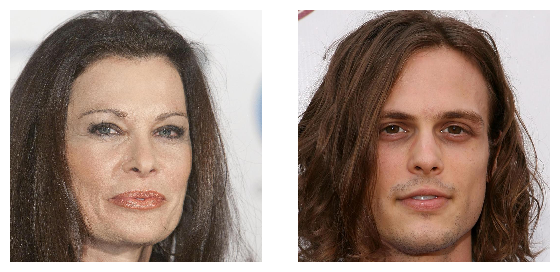

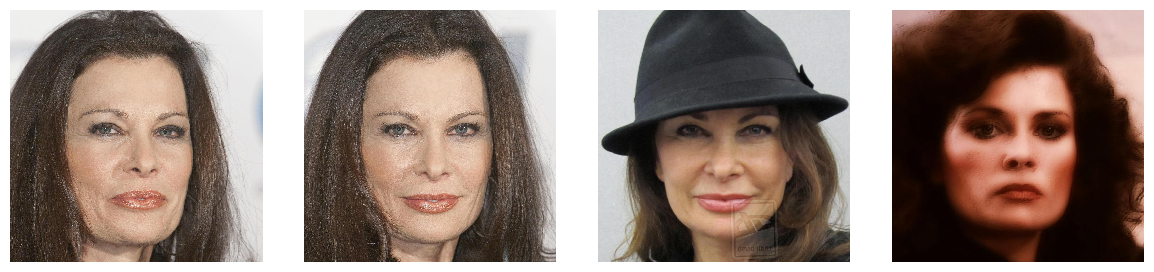

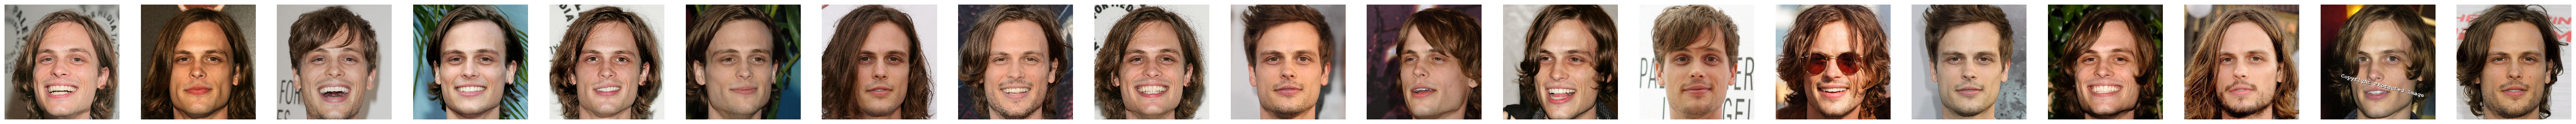

In [19]:
im_idx = 38 # img 38 is a good gender example
fname_id2 = '02638' # this is the match
# if all images are calculated, then this is just 5-char string of im_idx + 1
fname_id = fname_ids[im_idx] 


# idxs
im = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
im2 = mpimg.imread(oj(DIR_ORIG, f'{fname_id2}.jpg'))

d1 = df[df.id == df.loc[fname_id].id]
d2 = df[df.id == df.loc[fname_id2].id]



util.plot_row([im, im2])
util.plot_row([mpimg.imread(oj(DIR_ORIG, f)) for f in d1.fname_final])
util.plot_row([mpimg.imread(oj(DIR_ORIG, f)) for f in d2.fname_final])

**look at images / reconstructions of the same person**

In [ ]:
d = df[df['count_with_this_id'] >= df['count_with_this_id'].max() - 1]
dd = d[d.id == d.iloc[0].id]
util.plot_row([mpimg.imread(oj(DIR_ORIG, f)) for f in dd.fname_final][:5])
util.plot_row([mpimg.imread(oj(DIR_GEN, f'{index}.png')) for index in dd.index][:5])

# evaluate matching with metrics

**how often do we return the same id?**

In [58]:
dists_match_names = ['facial', 'gan', 'gan_constrained']
d = df[df['count_with_this_id'] > 1]
d = df
d = d[[k for k in d.keys()
       if not ('md5' in k or 'file' in k or 'idx' in k or 'fname' in k or 'prob' in k or 'count_with' in k)]] # filter some keys we don't really care about

N_IMS = 1000
suffs = ['', '_diff']
errs_keys = ['err_top1', 'err_top5', 'err_top10']
numerical_keys = ['yaw', 'pitch', 'roll', 'background_mean', 'background_std', 'quality']
attr_keys = [kk for kk in d.keys() if not 'scores' in kk and not kk in numerical_keys]
all_keys = errs_keys + attr_keys + numerical_keys \
        + [kk + '_diff' for kk in attr_keys + numerical_keys]

In [59]:
r = {
    k: [] for k in all_keys + [kk + '_std' for kk in all_keys]
}

for dists_match_name in dists_match_names:
    if dists_match_name == 'facial':
        dists_match = dists_facial
    elif dists_match_name == 'gan':
        dists_match = dists_gan
    elif dists_match_name == 'gan_constrained':
        dists_match = dists_gan + (dists_facial > 0.6) * 1e3 # constraint for missclassificaiton
    lists = {
        k: [] for k in all_keys
    }
    print('calculating', dists_match_name)
    for im_idx in tqdm(range(N_IMS)):
        orig = d.iloc[im_idx]
        id_orig = orig.id

        # id retention
        dists_im = dists_match[im_idx]
        # these indexes are all in df.space (not d.space)
        matched_idxs = np.argsort(dists_im)
        matched_ids = df.iloc[matched_idxs].id.values
        matched_idxs_diff = matched_idxs[matched_ids[matched_ids != id_orig]]
        
        # to convert back to d, we get the index from df
        matched_df_index = df.iloc[matched_idxs].index.values
        matched_df_index_diff = df.iloc[matched_idxs_diff].index.values
        
        # preserving id
        lists['err_top1'].append(id_orig not in matched_ids[:1])
        lists['err_top5'].append(id_orig not in matched_ids[:5])
        lists['err_top10'].append(id_orig not in matched_ids[:10])
        
        # 2 types of matching
        # d_full = df.iloc[matched_idxs[:10]]
        d_full = df.loc[matched_df_index[:10]]
        d_diff = df.loc[matched_df_index_diff[:10]] # df.iloc[matched_idxs_diff[:10]]
        
        for dd, suff in zip([d_full, d_diff], suffs):
            # binary feats
            for k in attr_keys:
                lists[k + suff].append(np.mean(dd[k] != orig[k]))
            
            # numerical feats
            for k in numerical_keys:
                lists[k + suff].append(np.mean(np.abs(dd[k] - orig[k])))
    
    # condense into one value per key/dist
    for k in lists.keys():
        r[k].append(np.mean(lists[k]))
        r[k + '_std'].append(np.std(lists[k]))
            
r = pd.DataFrame.from_dict(r)
r.N_IMS = N_IMS
r.index = dists_match_names
r.to_pickle('processed/13_dist_stats.pkl')

  0%|          | 0/1000 [00:00<?, ?it/s]

calculating facial


  0%|          | 1/1000 [00:00<01:58,  8.43it/s]

calculating gan


  0%|          | 1/1000 [00:00<01:56,  8.56it/s]

calculating gan_constrained


100%|██████████| 1000/1000 [01:43<00:00,  9.69it/s]


# load and view the matches

In [62]:
r = pd.read_pickle('processed/13_dist_stats.pkl').round(3)
for k in all_keys:
    if not k in numerical_keys and not k.replace('_diff', '') in numerical_keys: # or k == 'quality':
        r[k] *= 100
        r[k + '_std'] *= 100
r['quality'] *= 100
# for k in r.keys():
#     if r.loc['gan', k] > r.loc['facial', k]:
#         print(k, f"{r.loc['gan', k] - r.loc['facial', k]:0.1f}")
# r #.round(3).style.background_gradient()
r[[k for k in r.keys() if '_diff' not in k]]

,err_top1,err_top5,err_top10,id,gender,hair-length,facial-hair,makeup,skin-color,age,...,race4_pred_std,gender_pred_std,age_pred_std,img_names_pred_std,yaw_std,pitch_std,roll_std,background_mean_std,background_std_std,quality_std
facial,8.9,6.2,6.1,39.4,1.1,13.4,7.6,27.4,7.8,13.0,...,15.7,17.2,31.8,0.0,7.670,3.752,1.461,17.523,8.169,0.029
gan,82.0,75.1,70.6,95.4,15.6,15.4,15.9,31.7,7.1,24.9,...,30.4,22.2,33.5,0.0,3.403,3.186,1.183,11.030,5.641,0.040
gan_constrained,36.8,18.2,13.0,58.8,1.2,13.1,7.7,27.9,7.9,13.9,...,17.3,16.4,31.8,0.0,5.727,3.521,1.306,15.886,7.477,0.030


In [63]:
rename = {
    'err_top1': 'ID (top1)',
    'race_pred': 'Race',
    'background_mean': 'Background Mean',
}
for k in ['gender', 'quality', 'yaw', 'pitch', 'roll']:
    rename[k] = k.capitalize()
r.index = ['Facial-rec dist', 'GAN dist', 'Combined']
id_attributes = ['err_top1', 'gender', 'race_pred']
image_attributes = ['Blurry', 'quality', 'background_mean', 'yaw', 'pitch', 'roll']
id_correlated_attributes = ['Mustache', 'Eyeglasses', 'Bangs', 'Wearing_Hat']
attrs = id_attributes + image_attributes + id_correlated_attributes

r2 = deepcopy(r).round(1)

# add in stddev
n = r2.shape[0]
for k in r2.keys():
    if not 'std' in k:
        r2[k] = [str(r2[k].values[i]) + ' $\pm$ ' +  str(np.round(r2[k + '_std'].values[i] / np.sqrt(n), 0))
                 for i in range(n)]

r3 = r2[attrs].rename(columns=rename)

In [64]:
# print(r3.to_latex())
r3

,ID (top1),Gender,Race,Blurry,Quality,Background Mean,Yaw,Pitch,Roll,Mustache,Eyeglasses,Bangs,Wearing_Hat
Facial-rec dist,8.9 $\pm$ 16.0,1.1 $\pm$ 4.0,11.5 $\pm$ 12.0,1.5 $\pm$ 6.0,6.7 $\pm$ 0.0,40.7 $\pm$ 10.0,14.2 $\pm$ 4.0,7.2 $\pm$ 2.0,2.4 $\pm$ 1.0,4.5 $\pm$ 8.0,4.1 $\pm$ 7.0,21.0 $\pm$ 14.0,4.4 $\pm$ 8.0
GAN dist,82.0 $\pm$ 22.0,15.6 $\pm$ 13.0,36.6 $\pm$ 17.0,1.3 $\pm$ 6.0,7.8 $\pm$ 0.0,33.9 $\pm$ 6.0,6.8 $\pm$ 2.0,5.7 $\pm$ 2.0,1.8 $\pm$ 1.0,5.1 $\pm$ 10.0,3.5 $\pm$ 8.0,18.0 $\pm$ 17.0,2.3 $\pm$ 8.0
Combined,36.8 $\pm$ 28.0,1.2 $\pm$ 4.0,15.8 $\pm$ 13.0,1.4 $\pm$ 6.0,6.7 $\pm$ 0.0,39.2 $\pm$ 9.0,11.0 $\pm$ 3.0,6.7 $\pm$ 2.0,2.1 $\pm$ 1.0,4.3 $\pm$ 8.0,3.3 $\pm$ 7.0,20.6 $\pm$ 14.0,2.9 $\pm$ 8.0


**also look at matches across dists**

In [ ]:
# r_diff = r[[a + '_diff' for a in attrs if f'{a}_diff' in r.keys()]]
# r_diff